In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [4]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [1]:
class PI_DeepONet:
    def __init__(self, m, ics_data, bcs_data, res_data, branch_layer, trunk_layer, lr, activation):
        self.m = m
        self.ics_data = ics_data
        self.bcs_data = bcs_data
        self.res_data = res_data
        self.activation = activation
        self.loss_log = []
        self.loss_res_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []

        self.branch_layer = branch_layer
        self.trunk_layer  = trunk_layer

        self.sess = tf.Session()
        self.branch_weights, self.branch_biases = self.initilize_NN(branch_layer)
        self.trunk_weights, self.trunk_biases   = self.initilize_NN(trunk_layer)
        self.bias = tf.Variable(tf.zeros([1], dtype=tf.float32), dtype=tf.float32)
        # initial condition
        self.u_i_tf  = tf.placeholder(tf.float32, shape=[None, self.m])
        self.t_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.s_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # boundary condition
        self.u_b_tf  = tf.placeholder(tf.float32, shape=[None, self.m])
        self.t1_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x1_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t2_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x2_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.s_b_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # collocation points
        self.u_r_tf  = tf.placeholder(tf.float32, shape=[None, self.m])
        self.t_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.s_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])

        self.operator = self.operator_net(self.u_r_tf, self.t_r_tf, self.x_r_tf)
        self.residual = self.residual_net(self.u_r_tf, self.t_r_tf, self.x_r_tf)
        self.s_r      = self.loss_res(self.u_r_tf, self.t_r_tf, self.x_r_tf, self.s_r_tf)
        self.s_i      = self.loss_ics(self.u_i_tf, self.t_i_tf, self.x_i_tf, self.s_i_tf)
        self.s_b      = self.loss_bcs(self.u_b_tf, self.t1_b_tf, self.x1_b_tf,
                                      self.t2_b_tf, self.x2_b_tf, self.s_b_tf)
        self.weight = 20
        self.loss     = self.weight*self.s_r + self.weight*self.s_i + self.s_b

        steps_per_decay = 1000
        decay_factor = 0.9
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(learning_rate = lr,
                                           global_step = self.global_step,
                                           decay_steps = steps_per_decay,
                                           decay_rate = decay_factor,
                                           staircase = True
                                           )
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss,
                                            global_step=self.global_step)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def callback(self, loss, sr, si, sb):
        print('Loss:%f,ic:%f,bc:%f,res:%f'%(loss, si, sb, sr))

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def train(self, max_iter=40000, batch_size=50):
        loss_value = np.inf
        saver=tf.train.Saver(max_to_keep=1)
        for iter in range(max_iter):
            self.sess.run(self.global_step)
            u_i, y_i, s_i = self.ics_data.get_batch()
            u_b, y_b, s_b = self.bcs_data.get_batch()
            u_r, y_r, s_r = self.res_data.get_batch()
            tf_dict = {
                self.u_r_tf  : u_r,
                self.t_r_tf  : y_r[:, 0][:, None],
                self.x_r_tf  : y_r[:, 1][:, None],
                self.s_r_tf  : s_r,
                self.u_i_tf  : u_i,
                self.t_i_tf  : y_i[:, 0][:, None],
                self.x_i_tf  : y_i[:, 1][:, None],
                self.s_i_tf  : s_i,
                self.u_b_tf  : u_b,
                self.t1_b_tf : y_b[:, 0][:, None],
                self.x1_b_tf : y_b[:, 1][:, None],
                self.t2_b_tf : y_b[:, 2][:, None],
                self.x2_b_tf : y_b[:, 3][:, None],
                self.s_b_tf  : s_b
            }
            _, loss_value, si, sb, sr= self.sess.run([self.optimizer,
                self.loss, self.s_i, self.s_b, self.s_r], tf_dict)
            self.loss_res_log.append(sr)
            self.loss_bcs_log.append(sb)
            self.loss_ics_log.append(si)
            self.loss_log.append(loss_value)
            self.sess.run(self.lr)
            saver.save(self.sess, "./train/PID B Un weight/ckpt/model.ckpt", global_step=iter+1)
            if iter % 100 == 0:
                print("第%d次 %f,ic %f,bc %f,res %f"%(iter, loss_value, si, sb, sr))
        # model_file=tf.train.latest_checkpoint('./train/PID B Un weight/ckpt/')
        # saver.restore(self.sess, model_file)
        print("第%d次的损失为%f"%(max_iter, loss_value))
        print("最终lr为%f"%(self.sess.run(self.lr)))

    def operator_net(self, u, t, x):
        branch_out = self.neural_net(u, self.branch_weights, self.branch_biases, self.activation)
        trunk_out  = self.neural_net(tf.concat([t, x], 1), self.trunk_weights, self.trunk_biases, self.activation)
        s = tf.reshape(tf.reduce_sum(tf.multiply(branch_out, trunk_out),
                     axis=1) + self.bias, [-1, 1])
        return s

    def residual_net(self, u, t, x):
        s_pred = self.operator_net(u, t, x)
        s_t  = tf.gradients(s_pred, t)[0]
        s_x  = tf.gradients(s_pred, x)[0]
        s_xx = tf.gradients(s_x, x)[0]
        f    = s_t + s_pred * s_x - 0.01 * s_xx
        return f

    def predict_s(self, u, t, x):
        s = self.sess.run(self.operator, {self.u_r_tf: u, self.t_r_tf : t, self.x_r_tf: x})
        return s

    def predict_f(self, u, t, x):
        s_r = self.sess.run(self.residual, {self.u_r_tf: u, self.t_r_tf : t, self.x_r_tf: x})
        return s_r

    def loss_res(self, u, t, x, s):
        f = self.residual_net(u, t, x)
        loss = tf.reduce_mean(tf.square(f - s))
        return loss

    def loss_ics(self, u, t, x, s):
        s_pred = self.operator_net(u, t, x)
        loss   =  tf.reduce_mean(tf.square(s_pred - s))
        return loss

    def loss_bcs(self, u, t1, x1, t2, x2, s):
        s_pred_1 = self.operator_net(u, t1, x1)
        s_pred_2 = self.operator_net(u, t2, x2)
        s_x_1    = tf.gradients(s_pred_1, x1)[0]
        s_x_2    = tf.gradients(s_pred_2, x2)[0]
        loss_bc1 = tf.reduce_mean(tf.square(s_pred_1 - s_pred_2))
        loss_bc2 = tf.reduce_mean(tf.square(s_x_1 - s_x_2))
        return loss_bc1 + loss_bc2

In [5]:
class DataGenerator():
    def __init__(self, u, y, s, batch_size):
        self.u = u
        self.y = y
        self.s = s
        self.batch_size = batch_size

    def get_batch(self):
        N = self.u.shape[0]
        index = np.random.randint(0, N, self.batch_size)
        u_ = self.u[index, :]
        y_ = self.y[index, :]
        s_ = self.s[index, :]
        return u_, y_, s_

In [6]:
# Geneate ics training data
def generate_one_ics_data(u0, m=101, P=101):
    t_0 = np.zeros((P, 1))
    x_0 = np.linspace(0, 1, P)[:, None]
    y = np.hstack([t_0, x_0])         # y_shape=(P, 2)
    u = np.tile(u0[None, :], (P, 1))  # u_shape=(P, m)
    s = u0                            # s_shape=(m,  )

    return u, y, s

In [7]:
# Geneate bcs training data
def generate_one_bcs_data(u0, m=101, P=101):
    t_bc = np.random.rand(P)[:, None]
    x_bc1 = np.zeros((P, 1))
    x_bc2 = np.ones((P, 1))
    y1 = np.hstack([t_bc, x_bc1])  # shape = (P, 2)
    y2 = np.hstack([t_bc, x_bc2])  # shape = (P, 2)

    u = np.tile(u0, (P, 1))        # shape = (P, m)
    y = np.hstack([y1, y2])        # shape = (P, 4)
    s = np.zeros((P, 1))           # shape = (P, 1)

    return u, y, s

In [8]:
# Geneate res training data
def generate_one_res_data(u0, m=101, P=1000):
    t_res = np.random.rand(P)[:, None]
    x_res = np.random.rand(P)[:, None]

    u = np.tile(u0, (P, 1))         # shape=(P, m)
    y = np.hstack([t_res, x_res])   # shape=(P, 2)
    s = np.zeros((P, 1))            # shape=(P, 1)

    return u, y, s

In [9]:
# Generate test data
def generate_one_test_data(idx, usol, m=101, P=101):
    u = usol[idx]
    u0 = u[0,:]

    t = np.linspace(0, 1, P)
    x = np.linspace(0, 1, P)
    T, X = np.meshgrid(t, x)

    s = u.T.flatten()            # shape=(P**2, 1)
    u = np.tile(u0, (P**2, 1))   # shape=(P**2, m)
    y = np.hstack([T.flatten()[:,None], X.flatten()[:,None]]) # shape=(P**2, 2)

    return u, y, s

In [10]:
def compute_error(idx, usol, m, P, model):
    # 生成一组测试数据，计算相对L2误差，使用jax.vmap较方便
    u_test, y_test, s_test = generate_one_test_data(idx, usol, m, P)

    u_test = u_test.reshape(P**2,-1)
    y_test = y_test.reshape(P**2,-1)
    s_test = s_test.reshape(P**2,-1)
    s_pred = model.predict_s(u_test, y_test[:, 0][:, None], y_test[:, 1][:, None])
    error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test)

    return error


In [11]:
path = './Burgers/Burger.mat'
data = scipy.io.loadmat(path)
usol = np.array(data['output'])
N = usol.shape[0]  # number of total input samples
N_train =1000      # number of input samples used for training
N_test = N - N_train  # number of input samples used for test
m = 101            # number of sensors for input samples
P_ics_train = 101   # number of locations for evulating the initial condition
P_bcs_train = 100    # number of locations for evulating the boundary condition
P_res_train = 2500   # number of locations for evulating the PDE residual
P_test = 101        # resolution of uniform grid for the test data

In [12]:
# 生成数据，并将数据处理成PI_DeepONet的输入类型
u0_train = usol[:N_train,0,:]   # input samples
u_ics = []
y_ics = []
s_ics = []
for i in range(u0_train.shape[0]):
    u, y, s = generate_one_ics_data(u0_train[i], m, P_ics_train)
    u_ics.append(u)
    y_ics.append(y)
    s_ics.append(s)

u_bcs = []
y_bcs = []
s_bcs = []
for i in range(u0_train.shape[0]):
    u, y, s = generate_one_bcs_data(u0_train[i], m, P_bcs_train)
    u_bcs.append(u)
    y_bcs.append(y)
    s_bcs.append(s)

u_res = []
y_res = []
s_res = []
for i in range(u0_train.shape[0]):
    u, y, s = generate_one_res_data(u0_train[i], m, P_res_train)
    u_res.append(u)
    y_res.append(y)
    s_res.append(s)
u_res = np.reshape(np.array(u_res), (-1, m))
u_ics = np.reshape(np.array(u_ics), (-1, m))
u_bcs = np.reshape(np.array(u_bcs), (-1, m))
y_res = np.reshape(np.array(y_res), (-1, 2))
y_ics = np.reshape(np.array(y_ics), (-1, 2))
y_bcs = np.reshape(np.array(y_bcs), (-1, 4))
s_res = np.reshape(np.array(s_res), (-1, 1))
s_ics = np.reshape(np.array(s_ics), (-1, 1))
s_bcs = np.reshape(np.array(s_bcs), (-1, 1))

batch_size = 5000
ics_data = DataGenerator(np.array(u_ics), np.array(y_ics), np.array(s_ics), batch_size)
bcs_data = DataGenerator(np.array(u_bcs), np.array(y_bcs), np.array(s_bcs), batch_size)
res_data = DataGenerator(np.array(u_res), np.array(y_res), np.array(s_res), batch_size)

In [18]:
lr = 1e-3
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]
pi_deeponet_tanh = PI_DeepONet(m, ics_data, bcs_data, res_data, branch_layers, trunk_layers, lr, tf.tanh)
start_time = time.time()
pi_deeponet_tanh.train(max_iter=20000)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

第0次 1.028464,ic 0.050216,bc 0.002504,res 0.001082
第100次 0.755488,ic 0.035033,bc 0.044749,res 0.000504
第200次 0.740360,ic 0.032362,bc 0.077389,res 0.000786
第300次 0.938800,ic 0.042829,bc 0.064307,res 0.000896
第400次 0.619500,ic 0.024027,bc 0.083493,res 0.002773
第500次 0.262499,ic 0.007950,bc 0.012939,res 0.004528
第600次 0.243703,ic 0.006861,bc 0.005330,res 0.005058
第700次 0.233386,ic 0.005834,bc 0.007094,res 0.005481
第800次 0.227082,ic 0.006270,bc 0.004843,res 0.004842
第900次 0.230622,ic 0.006663,bc 0.003614,res 0.004687
第1000次 0.215632,ic 0.005980,bc 0.004146,res 0.004594
第1100次 0.219227,ic 0.005453,bc 0.006223,res 0.005197
第1200次 0.220720,ic 0.006107,bc 0.005860,res 0.004636
第1300次 0.203937,ic 0.005150,bc 0.006343,res 0.004730
第1400次 0.212519,ic 0.005467,bc 0.005934,res 0.004862
第1500次 0.201228,ic 0.005680,bc 0.004936,res 0.004135
第1600次 0.209869,ic 0.005407,bc 0.006431,res 0.004765
第1700次 0.211429,ic 0.005411,bc 0.005591,res 0.004881
第1800次 0.186807,ic 0.004497,bc 0.009205,res 0.004383
第1900

In [19]:
error = []
for idx in range(N_train, N):
    error.append(compute_error(idx, usol, m, P_test, pi_deeponet_tanh))
error = np.array(error)
print(error.mean())

0.07513030565446285


In [20]:
u = usol[1400]
u0 = u[0,:]

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

s = u.T.flatten()
u = np.tile(u0, (P_test**2, 1))
y = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])


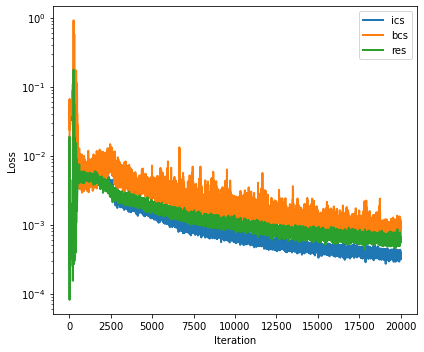

In [21]:
# Plot for loss function
plt.figure(figsize = (6,5))
# plt.plot(model.loss_log, lw=2)
plt.plot(pi_deeponet_tanh.loss_ics_log, lw=2, label='ics')
plt.plot(pi_deeponet_tanh.loss_bcs_log, lw=2, label='bcs')
plt.plot(pi_deeponet_tanh.loss_res_log, lw=2, label='res')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('loss.pdf')
plt.show()

error_s: 3.688e-02


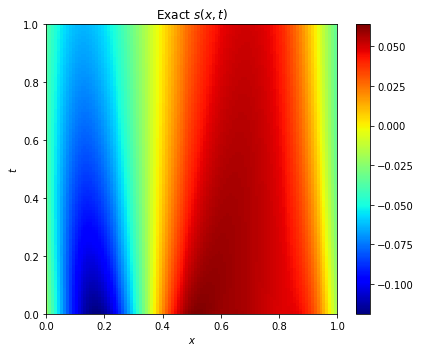

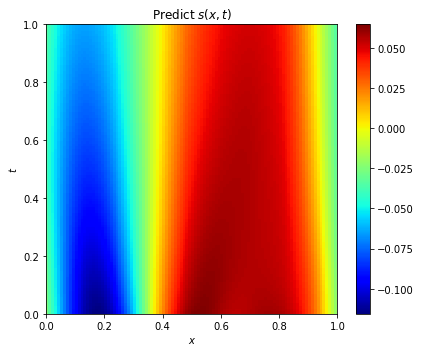

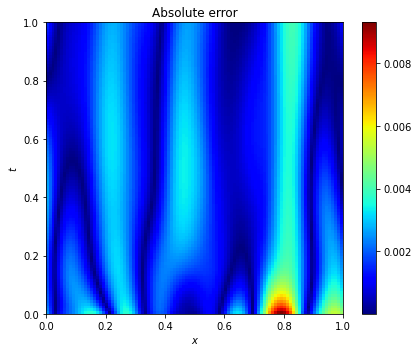

In [22]:
# Plot for one generated data
k = 1833 # index
u = usol[k,:, :]
u0 = usol[k,0,:]

P_test = 101

t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)

u_test = np.tile(u0, (P_test**2, 1))
y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
s_test = u.flatten()[:,None]

s_pred = pi_deeponet_tanh.predict_s(u_test, y_test[:, 0][:, None], y_test[:, 1][:, None])
S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')

error_s = np.linalg.norm(u - S_pred.T, 2) / np.linalg.norm(u, 2)

print("error_s: {:.3e}".format(error_s))

fig = plt.figure(figsize=(6,5))
plt.pcolor(T, X, u, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('Exact s.pdf')

fig = plt.figure(figsize=(6,5))
plt.pcolor(T, X, S_pred.T, cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.colorbar()
plt.tight_layout()
plt.savefig('Pred s.pdf')

fig = plt.figure(figsize=(6,5))
plt.pcolor(T, X, np.abs(S_pred.T - u), cmap='jet')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.colorbar()
plt.tight_layout()
plt.savefig('Absolute error.pdf')
plt.show()

In [ ]:
lr = 1e-3
branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]
pi_deeponet_relu = PI_DeepONet(m, ics_data, bcs_data, res_data, branch_layers, trunk_layers, lr, tf.nn.relu)
start_time = time.time()
pi_deeponet_relu.train(max_iter=20000)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))